# Prepping the final steps of PaddockTS
## These are the steps:
1. Import the data based on a "stub" identifier
    - time series Sentinel 1/2 after preprocessing and index calculations (*ds2i.pkl, *ds1.pkl) [note: Sentinel-1 is not currently implemented as not used currently in phenology inference]
    - paddock boundaries (*_filt.gpkg)
2. Aggregate the time series data to paddocks; save the paddock time series  as *_paddockTS_raw.pkl 
3. Resample, interpolate and smooth paddock time series
4. Break time series into "paddock years"
5. [possible add-in for later] filter paddock years with long stretches of missing data
6. Calculate phenology metrics for each paddock-year using phenolopy (https://github.com/lewistrotter/PhenoloPy/tree/main), which is a python implementation of TIMESAT (https://web.nateko.lu.se/timesat/timesat.asp)
7. [possible add-in for later] predict crop type (or crop/grazing/tree/other) using a classification model that should be trained and evaluated.
8. [possible add-in for later] predict flowering time for Canola/others (but this requires at least a rudimentary crop type classifier)
9. Plot paddock-year time series with raw/interpolated NDVI, and mark-up the estimated Start of Season (SoS), Peak of Season (PoS) and End of Season (EoS). (save as: ______)
10. Save the paddock phenolotrics (*_paddock_phenology_metrics.csv)

The steps are currently working and it's ready to convert into a .py script. 

Scroll down to MAIN to see where the steps are implemented.

This notebook has been tested with:
- stub = "TEST8", which is 2022-2023 for a cropping region.

In [1]:
# Most of these libs are doubled up below... 

import numpy as np
import pickle
import xarray as xr
import rioxarray  # activate the rio accessor
import matplotlib.pyplot as plt 
import rasterio
import os
import shutil
import geopandas as gpd


from affine import Affine
from rasterstats import zonal_stats
from concurrent.futures import ProcessPoolExecutor
from functools import partial

In [2]:
## A function for aggregating time series satellite time series to the median paddock value for each revisit. 
# This was working, but slow for larger datasets. Testing againts some alternative methods did not yield a better approach. Need a solution that is not compute/memory heavy, as this must run on laptops. 

import numpy as np
import xarray as xr
from concurrent.futures import ProcessPoolExecutor
import os

def _band_medians(band_array, mask_flat, paddock_ids):
    """
    band_array: np.ndarray (time, y, x)
    mask_flat:  1D np.ndarray of length y*x
    paddock_ids: list of ints, e.g. [1,2,...,18]
    """
    T, Y, X = band_array.shape
    flat   = band_array.reshape(T, -1)
    out    = np.empty((len(paddock_ids), T), dtype=np.float64)

    for t in range(T):
        row = flat[t]
        for i, pid in enumerate(paddock_ids):
            sel = row[mask_flat == pid]
            if sel.size and not np.all(np.isnan(sel)): # supresses warning in case where sel is all nan. 
                out[i, t] = np.nanmedian(sel)
            else:
                out[i, t] = np.nan

    return out

def make_paddockTS3(ds, pol, crs="epsg:6933"):
    # 1) rasterize once (pure numpy)
    import rasterio.features
    from affine import Affine

    ds = ds.rio.write_crs(crs, inplace=False)
    transform = ds.rio.transform()
    H, W = ds.rio.height, ds.rio.width

    shapes = [(geom, int(pid)) for geom, pid in zip(pol.geometry, pol.paddock)]
    mask = rasterio.features.rasterize(shapes,
                                       out_shape=(H, W),
                                       transform=transform,
                                       fill=0,
                                       dtype=np.int32)
    mask_flat   = mask.ravel()
    paddock_ids = pol.paddock.astype(int).tolist()
    paddock_str = [str(x) for x in paddock_ids]

    # 2) grab all band arrays in memory
    bands = {var: ds[var].values for var in ds.data_vars}

    # 3) parallel median for each band
    results = {}
    with ProcessPoolExecutor(max_workers=os.cpu_count()) as exe:
        futures = {
            var: exe.submit(_band_medians, arr, mask_flat, paddock_ids)
            for var, arr in bands.items()
        }
        for var, fut in futures.items():
            results[var] = fut.result()

    # 4) stitch back into xarray
    coords = {
        'paddock': paddock_str,
        'time':     ds.coords['time'],
        'spatial_ref': np.int32(ds.rio.crs.to_epsg())
    }
    data_vars = {
        var: (('paddock','time'), results[var])
        for var in results
    }
    return xr.Dataset(data_vars, coords=coords)


In [3]:
## An alternative approach that is closer to what I orignally did, and is more straighrforwards. But testing showed it a bit slower.. 
## Also tested using dask chunks, but I don't think it helps for the relatively small regions we're using. 

# Also note very slight differences in the output for this function. e.g. float 32 instead of 64. Minor differences in values (worrrying?)

import numpy as np
import xarray as xr
from joblib import Parallel, delayed
from tqdm import tqdm

def padts4(
    ds,
    polygons,
    paddock_col="paddock",
    var_names=None,
    ignore_zeros=True,
    n_jobs=-1,
):
    """
    Extract median time series for each paddock polygon by clipping the dataset.

    Parameters
    ----------
    ds : xarray.Dataset
        Time series satellite imagery with dims (time, y, x).
        Should be rioxarray-enabled (.rio.crs, .rio.transform).
    polygons : geopandas.GeoDataFrame
        GeoDataFrame with a geometry column and paddock attributes.
    paddock_col : str, default "paddock"
        Column name in `polygons` that uniquely identifies each paddock.
    var_names : list of str or None
        Subset of data variables in `ds` to process.
        If None, uses all data_vars in `ds`.
    ignore_zeros : bool, default False
        If True, ignore zero values when computing the median.
    n_jobs : int, default -1
        Number of parallel jobs for joblib. -1 uses all available cores.

    Returns
    -------
    xarray.Dataset
        Dataset with dims:
          - paddock
          - time
        and one data variable per input variable (e.g. nbart_blue, NDVI, ...),
        each with shape (paddock, time). Variables starting with "oa_" are
        excluded.
    """

    # Optionally restrict to a subset of variables
    if var_names is None:
        var_names = list(ds.data_vars.keys())
    ds_sub = ds[var_names]

    # Inner function: process one polygon
    def process_geometry(datarow, ds_local):
        # IMPORTANT: import rioxarray inside the worker process
        import rioxarray  # noqa: F401

        # Clip ds to this polygon geometry
        ds_clipped = ds_local.rio.clip([datarow.geometry])

        # Median over x, y for each time and variable
        if ignore_zeros:
            pol_ts = ds_clipped.where(ds_clipped != 0).median(dim=["x", "y"])
        else:
            pol_ts = ds_clipped.median(dim=["x", "y"])

        # Convert to array: (variable, time)
        arr = (
            pol_ts.to_array()           # dims: (variable, time)
                 .transpose("variable", "time")
                 .values
                 .astype(np.float32)
        )

        # Add leading axis for stacking (paddock dimension)
        return arr[None, :, :]   # shape: (1, n_variable, n_time)

    # Parallel over polygons
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_geometry)(datarow, ds_sub)
        for datarow in tqdm(polygons.itertuples(index=False), total=len(polygons))
    )

    # Stack into one big array: (paddock, variable, time)
    pvt_array = np.vstack(results)

    # Axes / coords
    time_axis = ds_sub.time
    var_axis = list(ds_sub.data_vars.keys())
    paddock_ids = polygons[paddock_col].values

    # Filter out variables starting with "oa_" before building the Dataset
    keep_vars = [v for v in var_axis if not v.startswith("oa_")]
    keep_indices = [var_axis.index(v) for v in keep_vars]

    # Build a Dataset with one data_var per band/index: (paddock, time)
    data_vars = {
        v: (("paddock", "time"), pvt_array[:, i, :])
        for i, v in zip(keep_indices, keep_vars)
    }

    ds_paddocks = xr.Dataset(
        data_vars=data_vars,
        coords={
            "paddock": paddock_ids,
            "time": time_axis,
        },
    )

    # Optionally carry spatial_ref coord across if present in input
    if "spatial_ref" in ds.coords:
        ds_paddocks = ds_paddocks.assign_coords(spatial_ref=ds.spatial_ref)

    return ds_paddocks


In [4]:
def resample_interpolate_smooth_paddocks(ds,
                                         days=10,
                                         window_length=7,
                                         polyorder=2):
    """
    Resample, conservatively interpolate, and smooth all time-dependent
    variables in a paddock-time xarray Dataset.

    The logic is identical to my function from ACT trees project:
      1. Separate non-time-dependent variables.
      2. Resample time-dependent data every `days` days (median).
      3. Interpolate missing values with PCHIP (conservative).
      4. Smooth with Savitzky–Golay.
      5. Re-attach static variables and return the new dataset.

        Parameters
    ----------
    ds : xarray.Dataset
        The input dataset.
    days : int, optional
        The resampling frequency in days (default is 10).
    window_length : int, optional
        The window length for the Savitzky–Golay filter (default is 7). This value must be odd. This is how many resampled obs the polynomial is fit to. 
    polyorder : int, optional
        The polynomial order for the Savitzky–Golay filter (default is 2). should be smaller than window_length. Higher orders let the filter follow curvature more closely but can re-introduce noise if the window is too short.
    """
    import numpy as np
    import xarray as xr
    from scipy.interpolate import PchipInterpolator
    from scipy.signal import savgol_filter

    # ─────────────────────────── 1. split vars ────────────────────────────
    time_dependent_vars = [v for v in ds.data_vars if "time" in ds[v].dims]
    non_time_dependent_vars = [v for v in ds.data_vars
                               if v not in time_dependent_vars]

    ds_non_time = ds[non_time_dependent_vars]  # may be empty
    ds_time_dep = ds[time_dependent_vars]

    # ─────────────────── 2. resample on a fixed grid ──────────────────────
    ds_resampled = ds_time_dep.resample(time=f"{days}D").median()
    ds_resampled = ds_resampled.transpose("paddock", "time")

    # ─────────────────── 3. interpolate with PCHIP ────────────────────────
    interp_dict = {}
    x = np.arange(ds_resampled.time.size)

    for var in time_dependent_vars:                           # loop over bands
        data = ds_resampled[var].values                       # (paddock, time)
        data_interp = np.empty_like(data, dtype=np.float64)

        for i in range(data.shape[0]):                        # loop paddocks
            y = data[i]
            valid = np.isfinite(y)                            # NaN or ±Inf safe
            if valid.sum() >= 2:
                try:
                    f = PchipInterpolator(x[valid], y[valid],
                                          extrapolate=True)
                    data_interp[i] = f(x)
                except ValueError:        # PCHIP can still fail (e.g. all equal)
                    data_interp[i] = np.nanmean(y) if valid.any() else np.nan
            else:
                data_interp[i] = np.nanmean(y) if valid.any() else np.nan

        # ─────────────── 4. Savitzky–Golay smoothing ────────────────
        wl = window_length + (window_length + 1) % 2           # make odd
        wl = min(wl, data_interp.shape[1] | 1)                 # ≤ n_time & odd
        data_smoothed = savgol_filter(data_interp,
                                      window_length=wl,
                                      polyorder=polyorder,
                                      axis=-1)
        interp_dict[var] = (("paddock", "time"), data_smoothed)

    # ─────────────────── 5. rebuild dataset ───────────────────────────────
    ds_new = ds_resampled.copy()
    for var, da in interp_dict.items():
        ds_new[var] = da
    for var in non_time_dependent_vars:
        ds_new[var] = ds_non_time[var]

    # keep original coords that might have been dropped (e.g. spatial_ref)
    for c in ds.coords:
        if c not in ds_new.coords:
            ds_new = ds_new.assign_coords({c: ds[c]})

    return ds_new


In [5]:
def split_paddockTS_by_year(ds):
    """
    Split paddock time series data by year, add day of year (doy) coordinate, and check for duplicate dates.
    
    Args:
        ds (xarray.Dataset): The input dataset containing time series data for each paddock.
        
    Returns:
        dict: A dictionary where each key is a year (int), and the value is an xarray.Dataset for that year,
              with an added 'doy' coordinate.
    """
    # Identify unique years in the 'time' coordinate (sorted)
    years = np.unique(ds.time.dt.year.values)
    
    # Dictionary to store datasets for each year
    datasets_by_year = {}
    
    for year in years:
        # Select data for the given year
        ds_year = ds.sel(time=ds.time.dt.year == year)

        # Useful bit of code if there are S1 data present, which can cause multi-obs on single day. 
        # # Check for multiple observations on the same date
        # dates = ds_year.time.dt.date.values
        # unique_dates, counts = np.unique(dates, return_counts=True)
        # duplicate_dates = unique_dates[counts > 1]
        
        # if duplicate_dates.size > 0:
        #     print(f"Multiple observations found on date(s) in {year}: {duplicate_dates}")
        # else:
        #     print(f"All observations in {year} occur on unique dates.")
        
        # Add an attribute for the year
        ds_year.attrs['year'] = int(year)
        
        # Calculate day of year (doy) from 'time' and add it as a new coordinate
        doy = ds_year.time.dt.dayofyear.data  # use .data to extract the underlying array
        ds_year = ds_year.assign_coords(doy=('time', doy))
        
        # Store the dataset in the dictionary
        datasets_by_year[int(year)] = ds_year

    return datasets_by_year

# Example usage:
# ds_paddock_years = split_paddockTS_by_year(ds_paddocks_ind)
# print(ds_paddock_years)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heatmap(ds, variable_name):
    """
    Plots a heatmap for the specified variable in the dataset.
    
    Parameters:
        ds (xarray.Dataset): Dataset with 'paddock' and 'time' as coordinates.
        variable_name (str): Name of the variable to plot (e.g., 'nbart_blue_median').
    """
    # Convert the DataArray into a pandas DataFrame
    # The index will be paddocks and columns will be time.
    df = ds[variable_name].to_pandas()
    
    # Format the dates as YYYY-MM-DD (assuming the columns are a DatetimeIndex)
    if isinstance(df.columns, pd.DatetimeIndex):
        df.columns = df.columns.strftime('%Y-%m-%d')
    
    plt.figure(figsize=(12, 8))
    
    # Plot the heatmap without annotations and with a shrunken colorbar.
    ax = sns.heatmap(df, cmap="viridis", annot=False, cbar_kws={"shrink": 0.5})
    
    # Set the colorbar title to the variable name.
    colorbar = ax.collections[0].colorbar
    colorbar.set_label(variable_name)
    
    # Set axis labels
    ax.set_xlabel("Observation Date")
    ax.set_ylabel("Paddock")
    
    # Rotate paddock (row) labels to be horizontal.
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    # No plot title is set.
    plt.show()

# Example usage:
# plot_heatmap(ds_paddocks, 'nbart_blue_median')

In [7]:
# This function will run phenolopy.calc_num_seasons and .calc_phenometrics given our resampled, interpolated "paddock-years" time series. 
# Must specify which variable to use, probably choose NDVI
# Important parameters are specified in phenolopy.calc_phenometrics() with big impacts on the results

# Need to replace this way of importing phenolopy with something stable across users. E.g. clone phenology into paddockts?
import sys
# sys.path.append('/g/data/xe2/John/Software/PhenoloPy/scripts')
sys.path.append('//home/106/jb5097/Projects/PaddockTS/PhenoloPy/scripts')
import phenolopy

import importlib
from contextlib import contextmanager

# Reload xarray to ensure a clean state
xr = importlib.reload(xr)

# Backup the original merge
_real_merge = xr.merge

@contextmanager
def override_xr_merge():
    """
    Context manager to temporarily override xarray.merge to use compat='override'.
    """
    # Define the override function
    def _override_merge(objs, *args, **kwargs):
        kwargs.pop("compat", None)
        return _real_merge(objs, compat="override", **kwargs)
    
    # Patch phenolopy's xarray reference
    phenolopy.xr.merge = _override_merge
    try:
        yield
    finally:
        # Restore the original merge
        phenolopy.xr.merge = _real_merge

def process_phenology(ds_yearly: dict, which_var: str) -> dict:
    """
    For each year in ds_yearly, computes the number of seasons and phenology metrics,
    returning a dict of pandas DataFrames (one per year).

    Parameters
    ----------
    ds_yearly : dict
        Mapping from year (int) to xarray.Dataset containing paddock time series.
    which_var : str
        Name of the data variable to process (e.g. 'NDVI').

    Returns
    -------
    dict of pd.DataFrame
        One DataFrame per year, indexed by paddock, with phenology metrics and num_seasons.
    """
    results = {}
    for year, ds in ds_yearly.items():
        # 1) Extract veg_index and drop doy
        ds_veg = (
            ds[[which_var]]
            .rename({which_var: "veg_index"})
            .drop_vars("doy")
        )
        
        # 2) Compute number of seasons per paddock
        da_num_seasons = phenolopy.calc_num_seasons(ds=ds_veg)
        
        # 3) Compute phenometrics with monkey-patched merge
        with override_xr_merge():
            ds_phenos = phenolopy.calc_phenometrics(
                da=ds_veg["veg_index"],
                peak_metric="pos",
                base_metric="bse",
                method="seasonal_amplitude",
                factor=0.05,
                thresh_sides="two_sided",
                abs_value=0,
            )
        
        # 4) Convert to DataFrame
        phenos_df = (
            ds_phenos
            .drop_vars(["spatial_ref", "time"])
            .to_dataframe()
            .reset_index()
        )
        
        # 5) Insert num_peaks column
        phenos_df["num_peaks"] = da_num_seasons.values
        
        # Store
        results[year] = phenos_df

    return results

# Example usage:
# phenology_results = process_phenology(ds_paddocks_resample_years, which_var="NDVI")

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

def plot_paddock_year_phenology_with_raw(phenology_results: dict,
                                         ds_paddocks_resample_years: dict,
                                         ds_paddocks: xr.Dataset,
                                         variable: str):
    """
    Overlay raw and interpolated data as specified:
    - Interpolated (smoothed) series: blue circles with solid white centers.
    - Raw series: blue circles with solid blue centers, plotted on top.

    Parameters
    ----------
    phenology_results : dict[int, pd.DataFrame]
        Year -> DataFrame with 'paddock', 'sos_times', 'pos_times', 'eos_times', 'num_seasons'.
    ds_paddocks_resample_years : dict[int, xr.Dataset]
        Year -> Dataset with interpolated time series and 'doy'.
    ds_paddocks : xr.Dataset
        Raw Dataset with dims ('time', 'paddock') and datetime64 time.
    variable : str
        Variable name to plot (e.g., 'NDVI').
    """
    years = sorted(ds_paddocks_resample_years.keys())
    paddocks = list(ds_paddocks_resample_years[years[0]].paddock.values)
    n_rows, n_cols = len(paddocks), len(years)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4 * n_cols, 1.5 * n_rows),
                             squeeze=False)

    for i, paddock in enumerate(paddocks):
        for j, year in enumerate(years):
            ax = axes[i, j]
            df_year = phenology_results[year]
            ds_year = ds_paddocks_resample_years[year]

            # Plot interpolated (smoothed) series first: blue edge, white fill
            da_res = ds_year[variable].sel(paddock=str(paddock))
            res_doy = ds_year['doy'].values
            ax.scatter(res_doy, da_res.values,
                       facecolors='white', edgecolors='blue',
                       s=20, label='interpolated')

            # Raw subset for this year and paddock
            ds_raw_year = ds_paddocks.sel(
                time=slice(f"{year}-01-01", f"{year}-12-31")
            )
            da_raw = ds_raw_year[variable].sel(paddock=str(paddock))
            raw_doy = da_raw['time'].dt.dayofyear.values

            # Plot raw points on top: solid blue circles
            ax.scatter(raw_doy, da_raw.values,
                       color='blue', s=20, label='raw')

            # Titles and labels
            if i == 0:
                ax.set_title(f"{year}", pad=8)
            if j == 0:
                ax.set_ylabel(variable)
            ax.set_xlabel("DOY")

            # Annotate phenology lines
            row = df_year[df_year['paddock'].astype(str) == str(paddock)]
            if not row.empty:
                r = row.iloc[0]
                ax.axvline(r['sos_times'], color='green', linestyle='--', label='SoS')
                ax.axvline(r['pos_times'], color='blue', linestyle='-.', label='PoS')
                ax.axvline(r['eos_times'], color='red', linestyle=':', label='EoS')

                bbox = dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round')
                ax.text(0.05, 0.9, f"Paddock {paddock}", transform=ax.transAxes,
                        va='top', bbox=bbox)
                ax.text(0.05, 0.7, f"n_peaks: {int(r['num_peaks'])}", transform=ax.transAxes,
                        va='top', bbox=bbox)

    # Add a single legend
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4)

    fig.tight_layout(rect=[0, 0, 1, 0.97])
    #plt.show()
    return fig

## phenolopy parameter selection:
from https://github.com/lewistrotter/PhenoloPy/blob/main/scripts/phenolopy.py

    peak_metric: str
        Sets the highest value for each pixel timeseries to use for calculations that rely on 
        the highest value. Can be either pos (peak of season), which is the single highest
        value in the whole timeseries per pixel, or mos (middle of season), which is the mean 
        of the highest vales in top 90 percentile. Default is pos.
    base_metric: str
        Sets the lowest value for each pixel timeseries to use for calculations that rely on 
        the lowest value. Can be either vos (valley of season), which is the lowest possible
        value in the whole timeseries per pixel, or bse (base), which is the mean of the min
        value on the left and right slopes of the time series. Default is bse.
    method: str
        Sets the method used to determine pos (peak of season) and eos (end of season). Can be
        first_of_slope, median_of_slope, seasonal_amplitude, absolute_value, relative_amplitude,
        or stl_trend. See the get_pos and/or get_eos methods for more information.
    factor: float (>=0 and <=1)
        A float value between 0 and 1 which is used to increase or decrease the amplitude
        threshold for the get_pos and get_eos seasonal_amplitude method. A factor closer 
        to 0 results in start of season nearer to min value, a factor closer to 1 results in 
        start of season closer to peak of season.
    thresh_sides: str
        A string indicating whether the sos value threshold calculation should be the min 
        value of left slope (one_sided) only, or use the bse/vos value (two_sided) calculated
        earlier. Default is two_sided, as per TIMESAT 3.3. That said, one_sided is potentially
        more robust.
    abs_value: float
        For absolute_value method only. Defines the absolute value in units of the vege index to
        which sos is defined. The part of the vege slope that the absolute value hits will be the
        sos value and time.   
More details about method:

    method: str
        A string indicating which start of season detection method to use. Default is
        same as TIMESAT: seasonal_amplitude. The available options include:
        1. first_of_slope: lowest vege value of slope is eos (i.e. first lowest value).
        2. median_of_slope: middle vege value of slope is eos (i.e. median value).
        3. seasonal_amplitude: uses a percentage of the amplitude from base to find eos.
        4. absolute_value: users defined absolute value in vege index units is used to find eos.
        5. relative_amplitude: robust mean peak and base, and a factor of that area, used to find eos.
        6. stl_trend: robust but slow - uses seasonal decomp LOESS method to find trend line and eos.

# MAIN

In [26]:
# # # OLDER SETUP (I since changed the way it reads in the ds2.pkl to ds2i.pkl (i for indexes), and also the directories. 
# OLD=True
# stub="TEST8"
# out_dir = "/g/data/xe2/John/Data/PadSeg/"
# tmp = "/g/data/xe2/John/Data/PadSeg/"

OLD = False
out_dir = "/g/data/xe2/jb5097/PaddockTS_Results/"
tmp = "/scratch/xe2/jb5097/tmp3/"

# stub="MILG_b04_2018-2024"
# stub="TEST11"

# # newer, smaller test region 
# stub="MILG_b01_2023-2024"

# newerer, smaller test region  but longer time. 
stub="MILG_b01_2018-2024"



In [27]:
filename = f"{out_dir}{stub}_{'ds2.pkl' if OLD else 'ds2i.pkl'}"

with open(filename, "rb") as handle:
    ds = pickle.load(handle)

print(ds)

<xarray.Dataset> Size: 2GB
Dimensions:           (time: 510, y: 213, x: 194)
Coordinates:
  * time              (time) datetime64[ns] 4kB 2018-01-05T00:02:32.457000 .....
  * y                 (y) float64 2kB -4.134e+06 -4.134e+06 ... -4.136e+06
  * x                 (x) float64 2kB 1.432e+07 1.432e+07 ... 1.433e+07
    spatial_ref       int32 4B 6933
Data variables: (12/16)
    nbart_blue        (time, y, x) float32 84MB 710.0 706.0 ... 507.0 510.0
    nbart_green       (time, y, x) float32 84MB 965.0 933.0 ... 782.0 785.0
    nbart_red         (time, y, x) float32 84MB 1.25e+03 1.245e+03 ... 727.0
    nbart_red_edge_1  (time, y, x) float32 84MB 1.438e+03 ... 1.244e+03
    nbart_red_edge_2  (time, y, x) float32 84MB 1.633e+03 ... 2.401e+03
    nbart_red_edge_3  (time, y, x) float32 84MB 1.831e+03 ... 2.983e+03
    ...                ...
    bg                (time, y, x) float64 169MB 0.1091 0.1038 ... 0.1235 0.1304
    pv                (time, y, x) float64 169MB 0.08001 0.06557 ... 

In [28]:
# read in the polygons and plot:
pol = gpd.read_file(out_dir+stub+'_filt.gpkg')
pol['paddock'] = range(1,len(pol)+1)
pol['paddock'] = pol.paddock.astype('category')
print(pol)

    area_ha  log_area_ha  perim-area  \
0      59.5     1.774517   22.857143   
1      43.9     1.642465   26.879271   
2     112.5     2.051153   15.466667   
3      17.5     1.243038   33.142857   
4      22.8     1.357935   31.578947   
5     108.0     2.033424   16.296296   
6     126.2     2.101059   14.738510   
7      41.7     1.620136   26.858513   
8      99.1     1.996074   14.934410   
9     221.6     2.345570   11.010830   
10    261.8     2.417970    9.167303   
11    178.0     2.250420   11.348315   
12    202.3     2.305996   12.259021   
13     44.5     1.648360   24.719101   
14    205.3     2.312389   10.618607   
15    383.9     2.584218    8.231310   
16    156.1     2.193403   11.787316   
17   1164.6     3.066177   17.911729   
18     78.8     1.896526   17.005076   
19     51.7     1.713491   22.437137   
20     57.8     1.761928   31.141869   

                                             geometry paddock  
0   POLYGON ((14324740.000 -4133970.000, 14325190....  

In [12]:
import time

In [13]:
## NEW VERSION 3 

start_time = time.time()

ds_paddocks_test = make_paddockTS3(ds, pol) # make-_paddockTS3 is currentl too slow. Find a previous version that worked better. 

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time (wall-clock): {elapsed_time} seconds")
print("--------------")

print(ds_paddocks_test)

Elapsed time (wall-clock): 2.547149896621704 seconds
--------------
<xarray.Dataset> Size: 443kB
Dimensions:           (paddock: 23, time: 150)
Coordinates:
  * time              (time) datetime64[ns] 1kB 2023-01-02T00:16:11.869498 .....
    spatial_ref       int32 4B 6933
  * paddock           (paddock) <U2 184B '1' '2' '3' '4' ... '20' '21' '22' '23'
Data variables: (12/16)
    nbart_blue        (paddock, time) float64 28kB 598.0 626.0 ... 572.5 585.0
    nbart_green       (paddock, time) float64 28kB 919.0 962.5 ... 872.0 870.5
    nbart_red         (paddock, time) float64 28kB 1.278e+03 1.391e+03 ... 884.5
    nbart_red_edge_1  (paddock, time) float64 28kB 1.782e+03 ... 1.367e+03
    nbart_red_edge_2  (paddock, time) float64 28kB 2.345e+03 ... 2.607e+03
    nbart_red_edge_3  (paddock, time) float64 28kB 2.711e+03 ... 3.224e+03
    ...                ...
    bg                (paddock, time) float64 28kB 0.06203 0.04009 ... 0.1523
    pv                (paddock, time) float64 28kB 0

### Testing paddockTS alogorithms:

In [29]:
# ORIGINAL Functions to generate paddock time series

import numpy as np
import xarray as xr
import geopandas as gpd
from joblib import Parallel, delayed
from tqdm import tqdm
import rioxarray  # needed in main process


def process_geometry(datarow, ds):
    import rioxarray  # needed in worker processes

    """
    Process each geometry to extract the median band values.
    Args:
        datarow: A row from the geopandas dataframe containing the geometry.
        ds: The xarray dataset with time series satellite imagery.
    Returns:
        A numpy array of median band values for the geometry over time.
        Shape: (1, n_variable, n_time)
    """
    # Clip the xarray dataset to the polygon
    ds_clipped = ds.rio.clip([datarow.geometry])

    # Extract the median band value, ignoring zero values
    pol_ts = ds_clipped.where(ds_clipped > 0).median(dim=["x", "y"])
    array = (
        pol_ts
        .to_array()                    # dims: (variable, time)
        .transpose("variable", "time")
        .values
        .astype(np.float32)
    )

    return array[None, :]  # shape: (1, n_variable, n_time)


def create_paddock_xarray(ds, pol):
    """
    Run process_geometry over all paddocks and return a Dataset where each
    original band/index is its own data variable with dims (paddock, time).

    Output format:
      Dimensions:
        paddock, time
      Coords:
        paddock, time, (optional) spatial_ref
      Data variables:
        nbart_blue(paddock, time), nbart_green(paddock, time), ..., NDVI, CFI, NIRv
    """

    # Parallel processing over polygons
    results = Parallel(n_jobs=-1)(
        delayed(process_geometry)(datarow, ds)
        for datarow in tqdm(pol.itertuples(index=True), total=len(pol))
    )

    # Stack results: (paddock, variable, time)
    pvt = np.vstack(results)
    print("Processing complete")
    print("pvt shape: ", pvt.shape)

    # Coordinates
    time_axis = ds.time
    var_names = list(ds.data_vars.keys())
    paddock_ids = pol.paddock.values  # or pol[paddock_col].values if you generalize

    # Optionally drop variables starting with "oa_" (like your earlier code)
    keep_vars = [v for v in var_names if not v.startswith("oa_")]
    keep_indices = [var_names.index(v) for v in keep_vars]

    # Build one data_var per band/index: (paddock, time)
    data_vars = {
        v: (("paddock", "time"), pvt[:, i, :].astype(np.float64))
        for i, v in zip(keep_indices, keep_vars)
    }

    ds_paddocks = xr.Dataset(
        data_vars=data_vars,
        coords={
            "paddock": paddock_ids,
            "time": time_axis,
        },
    )

    # If the original ds has spatial_ref, carry it over as a coord
    if "spatial_ref" in ds.coords:
        ds_paddocks = ds_paddocks.assign_coords(spatial_ref=ds.spatial_ref)

    return ds_paddocks




In [30]:
%time print(padts4(ds, pol))

100%|██████████| 21/21 [00:01<00:00, 17.56it/s]


<xarray.Dataset> Size: 690kB
Dimensions:           (paddock: 21, time: 510)
Coordinates:
  * time              (time) datetime64[ns] 4kB 2018-01-05T00:02:32.457000 .....
    spatial_ref       int32 4B 6933
  * paddock           (paddock) category 189B 1 2 3 4 5 6 ... 16 17 18 19 20 21
Data variables: (12/16)
    nbart_blue        (paddock, time) float32 43kB 671.0 671.0 ... -999.0 -999.0
    nbart_green       (paddock, time) float32 43kB 974.5 938.0 ... -999.0 -999.0
    nbart_red         (paddock, time) float32 43kB 955.0 1.216e+03 ... -999.0
    nbart_red_edge_1  (paddock, time) float32 43kB 1.526e+03 ... -999.0
    nbart_red_edge_2  (paddock, time) float32 43kB 2.467e+03 ... -999.0
    nbart_red_edge_3  (paddock, time) float32 43kB 2.796e+03 ... -999.0
    ...                ...
    bg                (paddock, time) float32 43kB 0.1803 0.1908 ... 0.1682
    pv                (paddock, time) float32 43kB 0.6961 0.2235 ... 0.6865
    npv               (paddock, time) float32 43kB 0.12

In [31]:
%time print(make_paddockTS3(ds, pol))

<xarray.Dataset> Size: 1MB
Dimensions:           (paddock: 21, time: 510)
Coordinates:
  * time              (time) datetime64[ns] 4kB 2018-01-05T00:02:32.457000 .....
    spatial_ref       int32 4B 6933
  * paddock           (paddock) <U2 168B '1' '2' '3' '4' ... '18' '19' '20' '21'
Data variables: (12/16)
    nbart_blue        (paddock, time) float64 86kB 688.0 687.0 ... 595.0 598.0
    nbart_green       (paddock, time) float64 86kB 995.0 954.0 ... 903.0 906.0
    nbart_red         (paddock, time) float64 86kB 990.0 1.248e+03 ... 861.0
    nbart_red_edge_1  (paddock, time) float64 86kB 1.568e+03 ... 1.379e+03
    nbart_red_edge_2  (paddock, time) float64 86kB 2.51e+03 ... 2.777e+03
    nbart_red_edge_3  (paddock, time) float64 86kB 2.848e+03 ... 3.384e+03
    ...                ...
    bg                (paddock, time) float64 86kB 0.1803 0.1908 ... 0.1682
    pv                (paddock, time) float64 86kB 0.6961 0.2235 ... 0.6865
    npv               (paddock, time) float64 86kB 0.

In [48]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:           (time: 510, y: 213, x: 194)
Coordinates:
  * time              (time) datetime64[ns] 4kB 2018-01-05T00:02:32.457000 .....
  * y                 (y) float64 2kB -4.134e+06 -4.134e+06 ... -4.136e+06
  * x                 (x) float64 2kB 1.432e+07 1.432e+07 ... 1.433e+07
    spatial_ref       int32 4B 6933
Data variables: (12/16)
    nbart_blue        (time, y, x) float32 84MB 710.0 706.0 ... 507.0 510.0
    nbart_green       (time, y, x) float32 84MB 965.0 933.0 ... 782.0 785.0
    nbart_red         (time, y, x) float32 84MB 1.25e+03 1.245e+03 ... 727.0
    nbart_red_edge_1  (time, y, x) float32 84MB 1.438e+03 ... 1.244e+03
    nbart_red_edge_2  (time, y, x) float32 84MB 1.633e+03 ... 2.401e+03
    nbart_red_edge_3  (time, y, x) float32 84MB 1.831e+03 ... 2.983e+03
    ...                ...
    bg                (time, y, x) float64 169MB 0.1091 0.1038 ... 0.1235 0.1304
    pv                (time, y, x) float64 169MB 0.08001 0.06557 ... 0.7469
    npv               (time, y, x) float64 169MB 0.8085 0.8288 ... 0.1312 0.1234
    NDVI              (time, y, x) float32 84MB 0.232 0.2265 ... 0.6327 0.6346
    CFI               (time, y, x) float32 84MB 572.9 544.7 ... 1.134e+03
    NIRv              (time, y, x) float32 84MB 465.1 447.0 ... 2.064e+03
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [32]:
# original way:
%time print(create_paddock_xarray(ds, pol))

100%|██████████| 21/21 [00:00<00:00, 5511.91it/s]


Processing complete
pvt shape:  (21, 16, 510)
<xarray.Dataset> Size: 1MB
Dimensions:           (paddock: 21, time: 510)
Coordinates:
  * time              (time) datetime64[ns] 4kB 2018-01-05T00:02:32.457000 .....
    spatial_ref       int32 4B 6933
  * paddock           (paddock) category 189B 1 2 3 4 5 6 ... 16 17 18 19 20 21
Data variables: (12/16)
    nbart_blue        (paddock, time) float64 86kB 688.0 687.0 ... 595.0 598.0
    nbart_green       (paddock, time) float64 86kB 995.0 954.0 ... 903.0 906.0
    nbart_red         (paddock, time) float64 86kB 990.0 1.248e+03 ... 861.0
    nbart_red_edge_1  (paddock, time) float64 86kB 1.568e+03 ... 1.379e+03
    nbart_red_edge_2  (paddock, time) float64 86kB 2.51e+03 ... 2.777e+03
    nbart_red_edge_3  (paddock, time) float64 86kB 2.848e+03 ... 3.384e+03
    ...                ...
    bg                (paddock, time) float64 86kB 0.1803 0.1908 ... 0.1682
    pv                (paddock, time) float64 86kB 0.6961 0.2235 ... 0.6865
    npv 

### Continuing from where we left off. 

In [33]:
ds_paddocks = make_paddockTS3(ds, pol)

In [34]:
# save the raw paddockTS
outdir = out_dir
out_name = os.path.join(outdir, stub + '_paddockTS_raw.pkl')
with open(out_name, 'wb') as f:
    pickle.dump(ds_paddocks, f, protocol=pickle.HIGHEST_PROTOCOL)
#logging.info(f"Data saved successfully to {out_name}")

In [35]:
print("Saving raw paddock time series data to:", out_name)

Saving raw paddock time series data to: /g/data/xe2/jb5097/PaddockTS_Results/MILG_b01_2018-2024_paddockTS_raw.pkl


In [36]:
ds_paddocks_resample = resample_interpolate_smooth_paddocks(ds_paddocks,
                                         days=10,
                                         window_length=5,
                                         polyorder=2)
print(ds_paddocks_resample)

<xarray.Dataset> Size: 690kB
Dimensions:           (paddock: 21, time: 256)
Coordinates:
  * paddock           (paddock) <U2 168B '1' '2' '3' '4' ... '18' '19' '20' '21'
  * time              (time) datetime64[ns] 2kB 2018-01-05 ... 2024-12-29
    spatial_ref       int32 4B 6933
Data variables: (12/16)
    nbart_blue        (paddock, time) float64 43kB 680.5 742.2 ... 595.4 601.5
    nbart_green       (paddock, time) float64 43kB 988.7 1.015e+03 ... 921.1
    nbart_red         (paddock, time) float64 43kB 1.024e+03 1.269e+03 ... 850.7
    nbart_red_edge_1  (paddock, time) float64 43kB 1.575e+03 ... 1.398e+03
    nbart_red_edge_2  (paddock, time) float64 43kB 2.445e+03 ... 2.857e+03
    nbart_red_edge_3  (paddock, time) float64 43kB 2.767e+03 ... 3.495e+03
    ...                ...
    bg                (paddock, time) float64 43kB 0.1877 0.1808 ... 0.1705
    pv                (paddock, time) float64 43kB 0.647 0.2603 ... 0.7636
    npv               (paddock, time) float64 43kB 0.164

In [37]:
ds_paddocks_resample_years = split_paddockTS_by_year(ds_paddocks_resample)
print(ds_paddocks_resample_years)

{2018: <xarray.Dataset> Size: 100kB
Dimensions:           (paddock: 21, time: 37)
Coordinates:
  * paddock           (paddock) <U2 168B '1' '2' '3' '4' ... '18' '19' '20' '21'
  * time              (time) datetime64[ns] 296B 2018-01-05 ... 2018-12-31
    spatial_ref       int32 4B 6933
    doy               (time) int64 296B 5 15 25 35 45 55 ... 325 335 345 355 365
Data variables: (12/16)
    nbart_blue        (paddock, time) float64 6kB 680.5 742.2 ... 751.8 800.4
    nbart_green       (paddock, time) float64 6kB 988.7 1.015e+03 ... 1.122e+03
    nbart_red         (paddock, time) float64 6kB 1.024e+03 ... 1.519e+03
    nbart_red_edge_1  (paddock, time) float64 6kB 1.575e+03 ... 1.796e+03
    nbart_red_edge_2  (paddock, time) float64 6kB 2.445e+03 ... 2.096e+03
    nbart_red_edge_3  (paddock, time) float64 6kB 2.767e+03 ... 2.369e+03
    ...                ...
    bg                (paddock, time) float64 6kB 0.1877 0.1808 ... 0.2377 0.266
    pv                (paddock, time) float64 

In [38]:
which_var = 'NDVI' # specify which variable to use

phenology_results = process_phenology(ds_paddocks_resample_years, which_var=which_var)


Beginning calculation of number of seasons.
> Calculating number of seasons.
> Success!

Initialising calculation of phenometrics.

Beginning extraction of CRS metadata.
> Extracting CRS metadata.
> No CRS metadata found. Returning None.

Beginning calculation of phenometrics. This can take awhile - please wait.

Beginning calculation of peak of season (pos) values and times.
> Calculating peak of season (pos) values.
> Calculating peak of season (pos) times.
> Success!

Beginning calculation of valley of season (vos) values and times.
> Calculating valley of season (vos) values.
> Calculating valley of season (vos) times.
> Success!

Beginning calculation of middle of season (mos) values (times not possible).
> Calculating middle of season (mos) values.
> Success!

Beginning calculation of base (bse) values (times not possible).
> Calculating base (bse) values.
> Success!

Beginning calculation of amplitude of season (aos) values (times not possible).
> Calculating amplitude of season

/g/data/xe2/John/geospatenv/lib64/python3.11/site-packages/xarray/core/duck_array_ops.py:246: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


> Could not add CRS metadata to data. Aborting.

Phenometrics calculated successfully!
Beginning calculation of number of seasons.
> Calculating number of seasons.
> Success!

Initialising calculation of phenometrics.

Beginning extraction of CRS metadata.
> Extracting CRS metadata.
> No CRS metadata found. Returning None.

Beginning calculation of phenometrics. This can take awhile - please wait.

Beginning calculation of peak of season (pos) values and times.
> Calculating peak of season (pos) values.
> Calculating peak of season (pos) times.
> Success!

Beginning calculation of valley of season (vos) values and times.
> Calculating valley of season (vos) values.
> Calculating valley of season (vos) times.
> Success!

Beginning calculation of middle of season (mos) values (times not possible).
> Calculating middle of season (mos) values.
> Success!

Beginning calculation of base (bse) values (times not possible).
> Calculating base (bse) values.
> Success!

Beginning calculation of a

/g/data/xe2/John/geospatenv/lib64/python3.11/site-packages/xarray/core/duck_array_ops.py:246: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [39]:
# convert paddock year phenology metrics to a single table and export it:

def save_paddock_year_phenology(phenology_results: dict,
                                out_dir: str,
                                stub: str,
                               which_var = which_var):
    """
    Combines the year‐indexed phenology_results dict of DataFrames into a single DataFrame,
    adds a 'year' column, and saves to csv
    """
    # 1) Add year column and collect
    frames = []
    for year, df in phenology_results.items():
        df2 = df.copy()
        df2['year'] = year
        frames.append(df2)

    # 2) Concatenate
    all_df = pd.concat(frames, ignore_index=True)

    # 3) Reorder columns (optional): paddock, year, then everything else
    cols = ['paddock', 'year'] + [c for c in all_df.columns if c not in ('paddock','year')]
    all_df = all_df[cols]

    # 4) Save to CSV
    path = os.path.join(out_dir, f"{stub}_paddock_year_phenology_{which_var}.csv")
    all_df.to_csv(path, index=False)
    print(f"Saved: {path}")
    
    return all_df

In [40]:
all_df = save_paddock_year_phenology(phenology_results, out_dir, stub, which_var)
all_df

Saved: /g/data/xe2/jb5097/PaddockTS_Results/MILG_b01_2018-2024_paddock_year_phenology_NDVI.csv


,paddock,year,pos_values,pos_times,mos_values,vos_values,vos_times,bse_values,aos_values,sos_values,...,eos_values,eos_times,los_values,roi_values,rod_values,lios_values,sios_values,liot_values,siot_values,num_peaks
0,1,2018,0.484721,5.0,0.456926,0.143976,155.0,0.314348,0.170373,NaN,...,0.316686,355.0,355.0,NaN,0.000480,9.468378,-1.690992,9.600851,-1.715694,1
1,2,2018,0.739501,245.0,0.687950,0.232602,45.0,0.245279,0.494222,0.295328,...,0.266947,365.0,250.0,0.003417,0.003938,11.607332,5.352715,15.224506,6.394460,1
2,3,2018,0.793787,245.0,0.713596,0.160938,145.0,0.175366,0.618421,0.192921,...,0.204419,325.0,260.0,0.003338,0.007367,11.620749,6.885856,13.604084,7.290894,1
3,4,2018,0.230046,245.0,0.204253,0.139243,105.0,0.146648,0.083399,0.152691,...,0.154053,345.0,230.0,0.000595,0.000760,4.458421,0.938871,6.437199,1.157874,1
4,5,2018,0.682837,245.0,0.646159,0.225207,45.0,0.230561,0.452276,0.239009,...,0.251303,295.0,240.0,0.002336,0.008631,10.392160,4.628125,14.384282,6.084072,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,17,2024,0.877612,164.0,0.828973,0.172409,94.0,0.206787,0.670824,0.238113,...,0.276233,364.0,260.0,0.010658,0.003007,17.565292,12.085427,20.421734,12.977387,2
143,18,2024,0.749797,244.0,0.683789,0.299391,84.0,0.303653,0.446143,0.319690,...,0.307916,324.0,230.0,0.002867,0.005524,13.329249,6.041571,18.847313,7.915794,1
144,19,2024,0.883150,164.0,0.819367,0.172732,84.0,0.199214,0.683937,0.271413,...,0.225695,334.0,230.0,0.010196,0.003867,17.112343,12.331218,20.533503,13.361814,2
145,20,2024,0.806517,164.0,0.771606,0.210233,324.0,0.243300,0.563217,0.276367,...,0.268504,314.0,230.0,0.006627,0.003587,14.494359,8.655165,20.124300,11.365509,1


In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

def plot_paddock_year_phenology_with_raw(phenology_results: dict,
                                         ds_paddocks_resample_years: dict,
                                         ds_paddocks: xr.Dataset,
                                         variable: str):
    """
    Overlay raw and interpolated data:
    - Interpolated: blue edge, white fill
    - Raw: solid blue circles, plotted on top
    Layout arranged by paddock rows and year columns.

    Customizations:
    1) X-axis label "DOY" only on bottom row panels.
    2) Paddock ID printed to the right of the rightmost panel.
    3) Y-axis limits fixed to [0,1]; tick labels only on leftmost column.
    """
    years = sorted(ds_paddocks_resample_years.keys())
    paddocks = list(ds_paddocks_resample_years[years[0]].paddock.values)
    n_rows, n_cols = len(paddocks), len(years)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4 * n_cols, 1.5 * n_rows),
                             squeeze=False)

    for i, paddock in enumerate(paddocks):
        for j, year in enumerate(years):
            ax = axes[i, j]
            df_year = phenology_results[year]
            ds_year = ds_paddocks_resample_years[year]

            # Interpolated series
            da_res = ds_year[variable].sel(paddock=str(paddock))
            res_doy = ds_year['doy'].values
            ax.scatter(res_doy, da_res.values,
                       facecolors='white', edgecolors='blue',
                       s=20, label='interpolated')

            # Raw series
            ds_raw_year = ds_paddocks.sel(
                time=slice(f"{year}-01-01", f"{year}-12-31")
            )
            da_raw = ds_raw_year[variable].sel(paddock=str(paddock))
            raw_doy = da_raw['time'].dt.dayofyear.values
            ax.scatter(raw_doy, da_raw.values,
                       color='blue', s=20, label='raw')

            # Phenology lines
            row = df_year[df_year['paddock'].astype(str) == str(paddock)]
            if not row.empty:
                r = row.iloc[0]
                ax.axvline(r['sos_times'], color='green', linestyle='--', label='SoS')
                ax.axvline(r['pos_times'], color='blue', linestyle='-.', label='PoS')
                ax.axvline(r['eos_times'], color='red', linestyle=':', label='EoS')

            # Y-axis limits and tick labels
            ax.set_ylim(0, 1)
            if j == 0:
                ax.tick_params(labelleft=True)
                ax.set_ylabel(variable)
            else:
                ax.tick_params(labelleft=False)

            # X-axis label only bottom row
            if i == n_rows - 1:
                ax.set_xlabel("DOY")
            else:
                ax.tick_params(labelbottom=False)

            # Title on top row
            if i == 0:
                ax.set_title(f"{year}", pad=8)

            # Paddock ID on rightmost column
            if j == n_cols - 1:
                ax.text(1.02, 0.5, f"Paddock {paddock}",
                        transform=ax.transAxes, va='center')

    # Single legend
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4)

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return fig


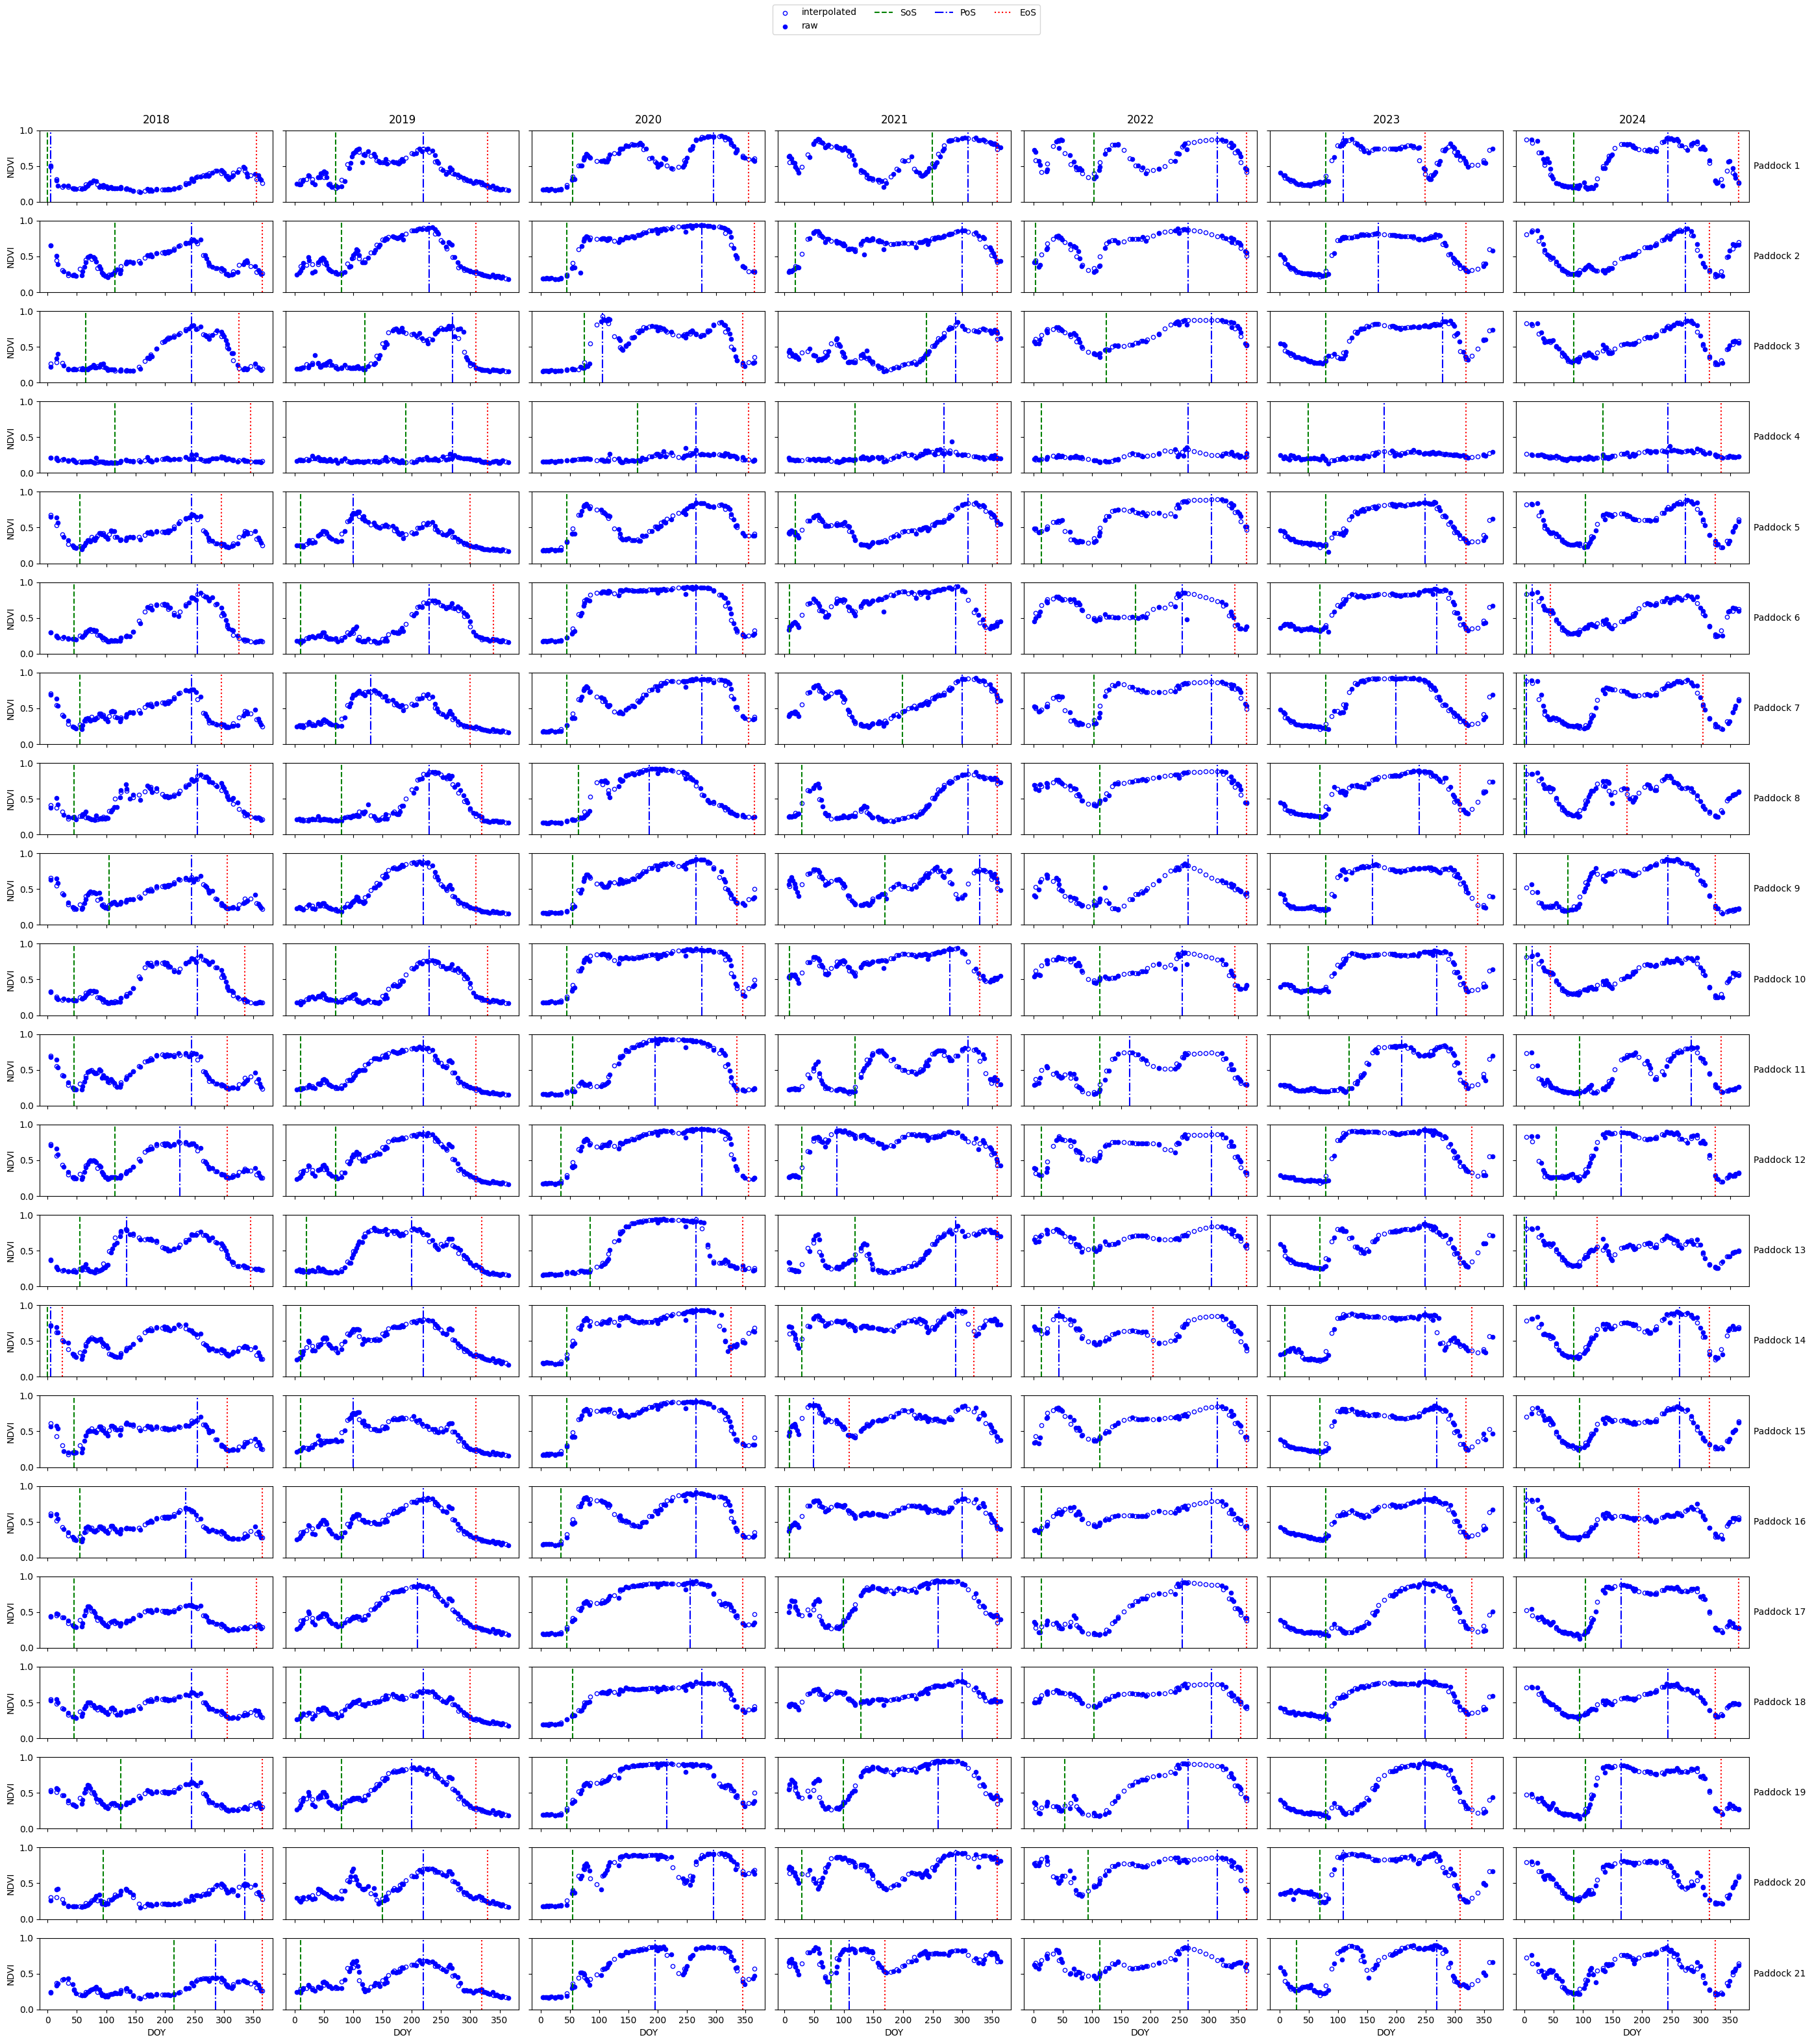

In [42]:
fig = plot_paddock_year_phenology_with_raw(
    phenology_results,
    ds_paddocks_resample_years,
    ds_paddocks,
    variable="NDVI"
)

#fig.savefig(out_dir+stub+"_paddock_year_phenology_"+which_var+".svg", format="svg", bbox_inches="tight")

In [43]:
fig.savefig(out_dir+stub+"_paddock_year_phenology_"+which_var+".png", format="png", bbox_inches="tight")# png is the way to go for this plot

## More analysis

Below is stuff that is interesting to keep in the notebook but not neccesary to move into the .py script

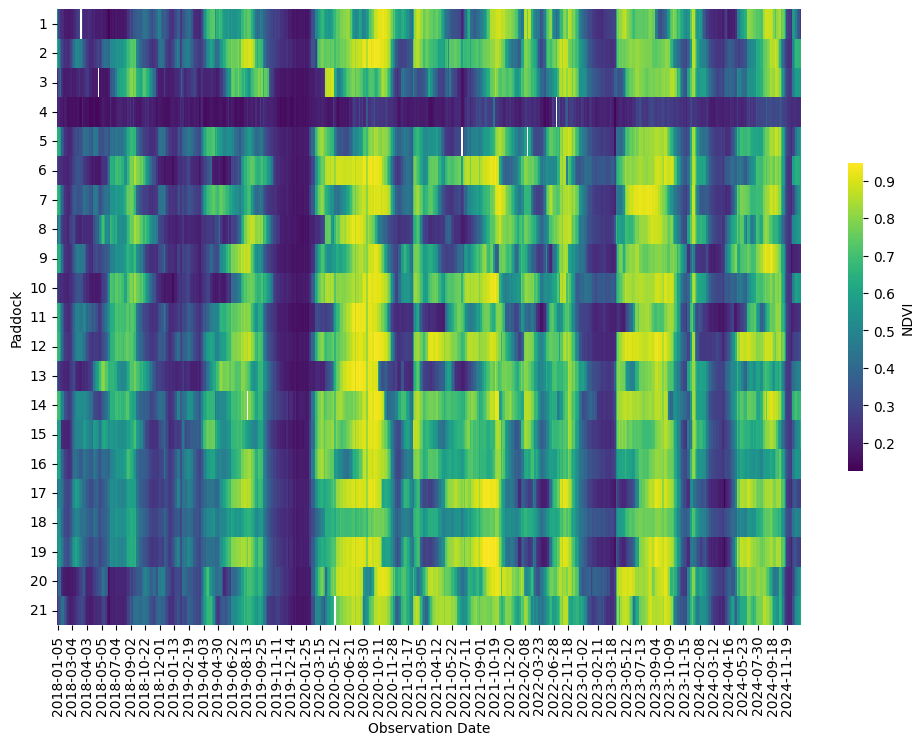

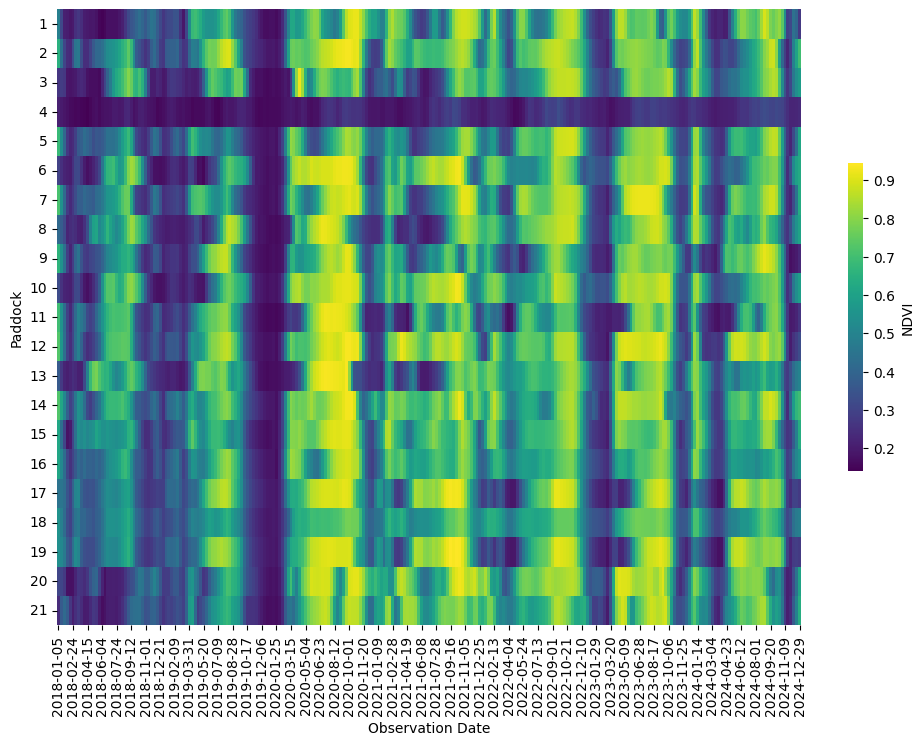

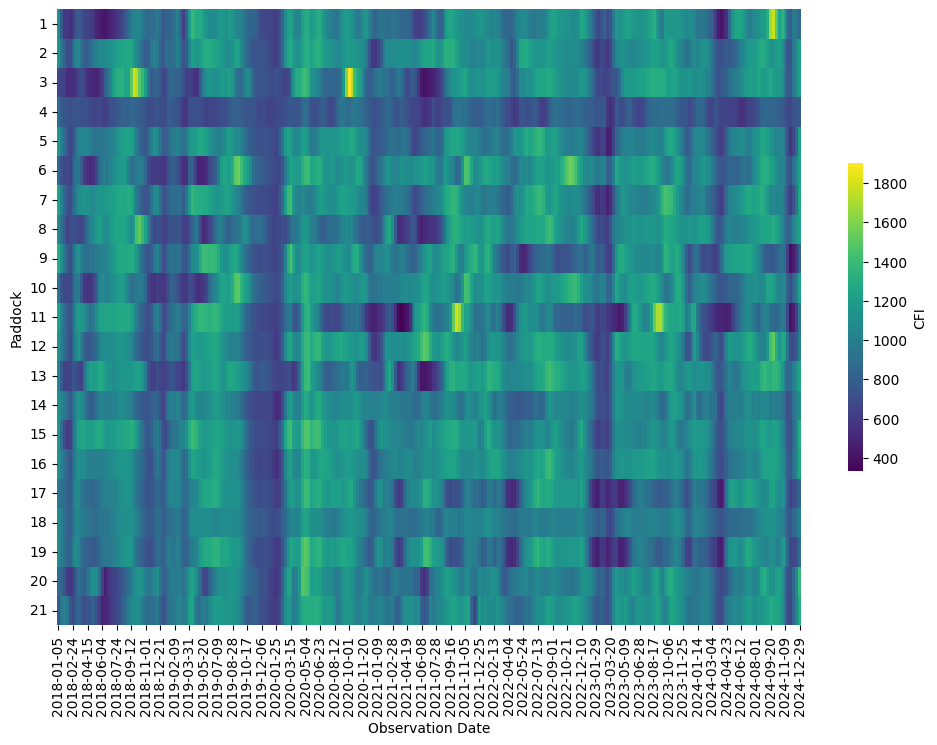

In [44]:
plot_heatmap(ds_paddocks, 'NDVI')
plot_heatmap(ds_paddocks_resample, 'NDVI')
# easy to predict which paddocks had canola
#plot_heatmap(ds_paddocks_resample_years[2023], 'CFI')
plot_heatmap(ds_paddocks_resample, 'CFI')

/jobfs/155699497.gadi-pbs/ipykernel_570663/3197755378.py:32: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_units = ds.dims[unit_dim]    # total paddocks


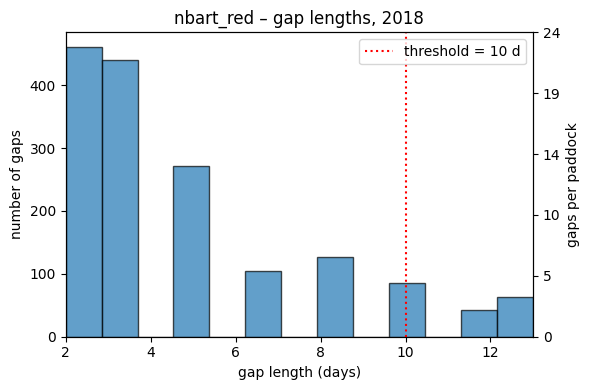

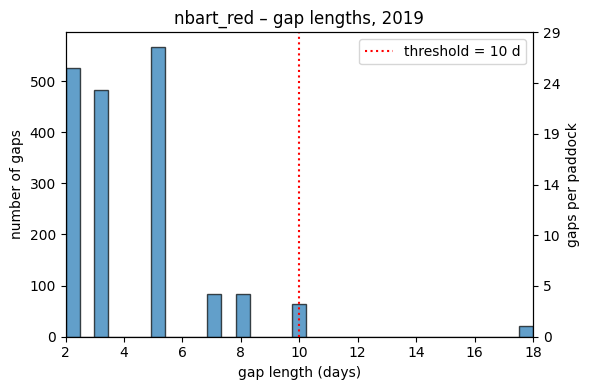

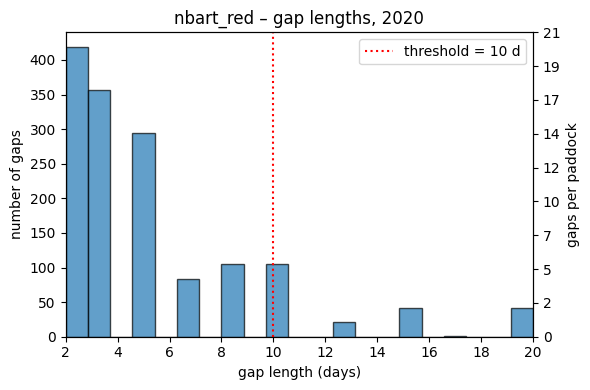

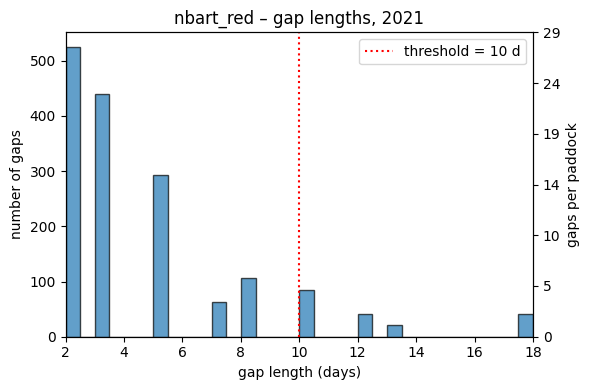

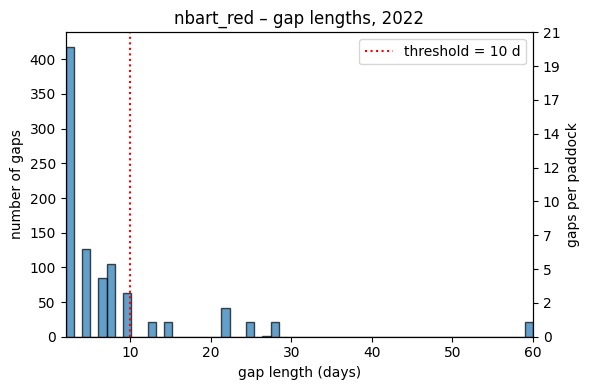

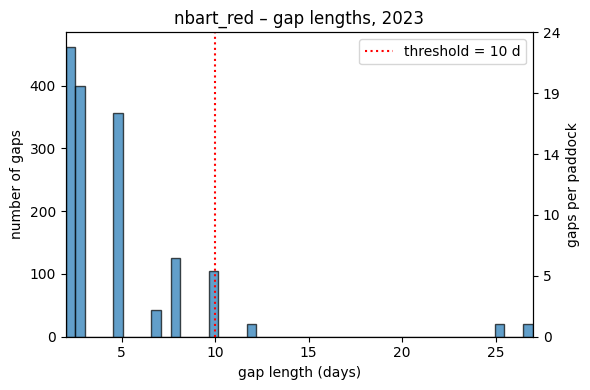

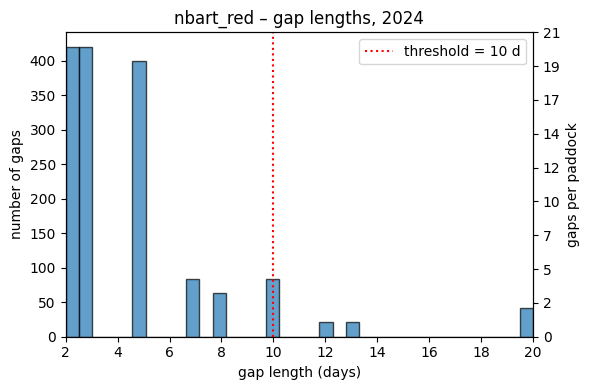

In [45]:
### Purpose of this function is to explore missing data in paddock time series. 


## November. Something seems off about the plots. Try it again.. (TO DO)

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt


def plot_gap_lengths_by_year(ds: xr.Dataset,
                             var: str = "nbart_red",
                             *,
                             unit_dim: str = "paddock",
                             time_dim: str = "time",
                             min_gap_days: int = 1,
                             bins: int | str = "auto",
                             figsize: tuple[int, int] = (6, 4),
                             show: bool = True) -> dict[int, list[int]]:
    """
    Histogram of calendar-day gaps between successive valid observations.

    • Left y-axis  : absolute count of gaps.
    • Right y-axis : count ÷ number-of-paddocks (tick labels rounded).

    A red dotted vertical line marks `min_gap_days`; x-axis spans [min, max].
    """
    if var not in ds.data_vars:
        raise KeyError(f"{var!r} not found in dataset.")

    da = ds[var]
    n_units = ds.dims[unit_dim]    # total paddocks

    def _gaps_in_days(times: np.ndarray) -> np.ndarray:
        if times.size < 2:
            return np.empty(0, dtype=int)
        deltas = np.diff(np.sort(times.astype("datetime64[D]")))
        return deltas.astype("timedelta64[D]").astype(int)

    gap_dict: dict[int, list[int]] = {}

    for yr, da_year in da.groupby(f"{time_dim}.year"):
        gaps_all: list[int] = []
        for unit in da_year[unit_dim]:
            times = da_year.sel({unit_dim: unit}).dropna(time_dim)[time_dim].values
            gaps_all.extend(_gaps_in_days(times))

        gap_dict[yr] = [g for g in gaps_all if g >= min_gap_days]

        if show:
            fig, ax = plt.subplots(figsize=figsize)

            # histogram
            counts, edges, _ = ax.hist(gaps_all, bins=bins,
                                       edgecolor="black", alpha=0.7)

            # secondary y-axis: same scale, labels = counts/n_units (rounded)
            ax2 = ax.twinx()
            ax2.set_ylim(ax.get_ylim())
            primary_ticks = ax.get_yticks()
            ax2.set_yticks(primary_ticks)
            ax2.set_yticklabels([str(int(round(y / n_units))) for y in primary_ticks])
            ax2.set_ylabel("gaps per paddock")

            # red dotted threshold
            ax.axvline(min_gap_days, color="red", linestyle="dotted",
                       linewidth=1.5, label=f"threshold = {min_gap_days} d")

            # axis limits
            if gaps_all:
                ax.set_xlim(min(gaps_all), max(gaps_all))
            else:
                ax.set_xlim(0, 1)

            ax.set_xlabel("gap length (days)")
            ax.set_ylabel("number of gaps")
            ax.set_title(f"{var} – gap lengths, {yr}")
            ax.legend(loc="upper right")

            plt.tight_layout()
            plt.show()

    return gap_dict

gap_stats = plot_gap_lengths_by_year(ds_paddocks,
                                     var="nbart_red",
                                     min_gap_days=10)
# Next time, the threshold should indicate a red dotted line, and the domain should cover min to max. 

In [46]:
ds_paddocks

<xarray.Dataset> Size: 1MB
Dimensions:           (paddock: 21, time: 510)
Coordinates:
  * time              (time) datetime64[ns] 4kB 2018-01-05T00:02:32.457000 .....
    spatial_ref       int32 4B 6933
  * paddock           (paddock) <U2 168B '1' '2' '3' '4' ... '18' '19' '20' '21'
Data variables: (12/16)
    nbart_blue        (paddock, time) float64 86kB 688.0 687.0 ... 595.0 598.0
    nbart_green       (paddock, time) float64 86kB 995.0 954.0 ... 903.0 906.0
    nbart_red         (paddock, time) float64 86kB 990.0 1.248e+03 ... 861.0
    nbart_red_edge_1  (paddock, time) float64 86kB 1.568e+03 ... 1.379e+03
    nbart_red_edge_2  (paddock, time) float64 86kB 2.51e+03 ... 2.777e+03
    nbart_red_edge_3  (paddock, time) float64 86kB 2.848e+03 ... 3.384e+03
    ...                ...
    bg                (paddock, time) float64 86kB 0.1803 0.1908 ... 0.1682
    pv                (paddock, time) float64 86kB 0.6961 0.2235 ... 0.6865
    npv               (paddock, time) float64 86kB 0.1229 0.5843 ... 0.1471
    NDVI              (paddock, time) float64 86kB 0.5086 0.294 ... 0.6126
    CFI               (paddock, time) float64 86kB 1.153e+03 727.3 ... 1.238e+03
    NIRv              (paddock, time) float64 86kB 1.532e+03 672.7 ... 2.222e+03

In [47]:
ds_paddocks_resample_years

{2018: <xarray.Dataset> Size: 100kB
 Dimensions:           (paddock: 21, time: 37)
 Coordinates:
   * paddock           (paddock) <U2 168B '1' '2' '3' '4' ... '18' '19' '20' '21'
   * time              (time) datetime64[ns] 296B 2018-01-05 ... 2018-12-31
     spatial_ref       int32 4B 6933
     doy               (time) int64 296B 5 15 25 35 45 55 ... 325 335 345 355 365
 Data variables: (12/16)
     nbart_blue        (paddock, time) float64 6kB 680.5 742.2 ... 751.8 800.4
     nbart_green       (paddock, time) float64 6kB 988.7 1.015e+03 ... 1.122e+03
     nbart_red         (paddock, time) float64 6kB 1.024e+03 ... 1.519e+03
     nbart_red_edge_1  (paddock, time) float64 6kB 1.575e+03 ... 1.796e+03
     nbart_red_edge_2  (paddock, time) float64 6kB 2.445e+03 ... 2.096e+03
     nbart_red_edge_3  (paddock, time) float64 6kB 2.767e+03 ... 2.369e+03
     ...                ...
     bg                (paddock, time) float64 6kB 0.1877 0.1808 ... 0.2377 0.266
     pv                (paddock

## Calendar plots
Revisiting old code. 
#### Inputs:
- The time series data dsi.pkl
- Paddock annotations

#### Do:
    - Make a weekly interpolated dataset of RGB.  
    - For a list of paddock names:
        - clip the RGB for the paddock and generate a year by week array of the paddock. 
        - Save it as png? 

    